### Import the needed Libraries

#### Documentation: https://pytorch.org/docs/stable/index.html
#### Youtube Tutorial: https://www.learnpytorch.io/
#### Github: https://github.com/mrdbourke/pytorch-deep-learning

In [ ]:
# pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# torchvision
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

# torchinfo
%pip install torchinfo
%pip install torchmetrics
from torchinfo import summary

# standard data handling
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# image
import random
from PIL import Image

# system
import pathlib
import glob
from pathlib import Path
import requests
import zipfile
import os
import shutil

# timing and printing
from tqdm.auto import tqdm
from timeit import default_timer as timer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Check the available pytorch and Cuda (GPU) Version

In [ ]:
# pytroch and cuda version
print(torch.__version__)

# trochvision and cuda version
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


### Check the available device

1. CPU (Default)
2. Cuda (GPU acceleration is accessible)

In [ ]:
# make device agnostic code (default is cpu)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Available device is: {device}")

Available device is: cpu


### Import Helper files

In [ ]:
# filenames
filenames = {"pytorch_helper_functions.py": "https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/pytorch_helper_functions.py",
             "training.py": "https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/training.py",
             "make_predictions.py":"https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/make_predictions.py",
             "validation.py":"https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/validation.py",
             "visualizing_images.py":"https://raw.githubusercontent.com/sl2000stat/PytorchIntroduction/master/visualizing_images.py",}

for filename, file_path in filenames.items():

  # download helper functions from repo
  if Path(filename).is_file():
    print(f"{filename} already exists. Skipping download")

  else:

    request = requests.get(file_path)
    with open(filename, "wb") as f:
      f.write(request.content)

    print(f"Downloaded {filename}.")

pytorch_helper_functions.py already exists. Skipping download
training.py already exists. Skipping download
make_predictions.py already exists. Skipping download
validation.py already exists. Skipping download
visualizing_images.py already exists. Skipping download


In [ ]:
from pytorch_helper_functions import set_global_seed

# set the global seed
set_global_seed(42)

### General Pytorch Workflow

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

1. **Getting data ready:** Data can be almost anything but to get started we're going to create a simple straight line
2. **Building a model:**	Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.
3. **Fitting the model to data (training):** We've got data and a model, now let's let the model (try to) find patterns in the (training) data.
4. **Making predictions and evaluating a model (inference):**	Our model's found patterns in the data, let's compare its findings to the actual (testing) data.
5. **Tune the model:**	Fine tune the hyperparameter and select the optimal model.
6. **Saving and loading a model:**	You may want to use your model elsewhere, or come back to it later, here we'll cover that.


### 2.0 Transfer learning

When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

In [ ]:
# use transfer learning
transfer_learning = False

In [ ]:
# optional:
if transfer_learning:

  # choose a model and get a set of pretrained model weights
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

  # get the transforms used to create our pretrained weights
  auto_transforms = weights.transforms()

  # get the model with the pretrained weights
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)

### 1. Get the Data

In [ ]:
# setup path to data folder
data_path = Path("data/")
image_path = data_path / "ML2-Dataset"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory already exists. Skipping dowload.")
else:
    print(f"Did not find {image_path} directory, creating one.")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "ML2-Dataset.zip", "wb") as f:
        request = requests.get("https://bwsyncandshare.kit.edu/s/ABCDfTbtTnETgFT/download/ML2-Dataset.zip")
        print("Downloading the data.")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "ML2-Dataset.zip", "r") as zip_ref:
        print("Unzipping the data.")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "ML2-Dataset.zip")

data/ML2-Dataset directory already exists. Skipping dowload.


In [ ]:
# due to the structure of the data the image path has to be adjusted
image_path = image_path / "student_dataset"

In [ ]:
from pytorch_helper_functions import walk_through_directory

# get all the paths
walk_through_directory(image_path)

There are 3 directories and 0 images in 'data/ML2-Dataset/student_dataset
There are 1 directories and 0 images in 'data/ML2-Dataset/student_dataset/test_color
There are 0 directories and 50 images in 'data/ML2-Dataset/student_dataset/test_color/images
There are 1 directories and 1 images in 'data/ML2-Dataset/student_dataset/train
There are 0 directories and 5656 images in 'data/ML2-Dataset/student_dataset/train/images
There are 1 directories and 0 images in 'data/ML2-Dataset/student_dataset/test_angvel
There are 0 directories and 1638 images in 'data/ML2-Dataset/student_dataset/test_angvel/images


### 1.0  For Final Training, combine train with test_angvel otherwise we use the 1000 pictures from test_angvel as vaildation data


In [ ]:
# source directory
# source_dir = image_path / "test_angvel/images"

# target directory
# target_dir = image_path / "train/images"

# for jpgfile in glob.iglob(os.path.join(source_dir, "*.jpg")):
#    shutil.copy(jpgfile, target_dir)

In [ ]:
# set the training and val paths
train_dir = image_path / "train"
val_dir = image_path / "test_angvel"
test_dir = image_path / "test_color"

# print
print(f"Train Path: {train_dir} | Val Path: {val_dir}| Val Path: {test_dir}")

Train Path: data/ML2-Dataset/student_dataset/train | Val Path: data/ML2-Dataset/student_dataset/test_angvel| Val Path: data/ML2-Dataset/student_dataset/test_color


### 1.2 Explore the Image Data

Data Visualization, Preperation and Exploration

Note: "Der Trainval Datensatz enthält 5656 Bilder mit Aufläsung 640×320"

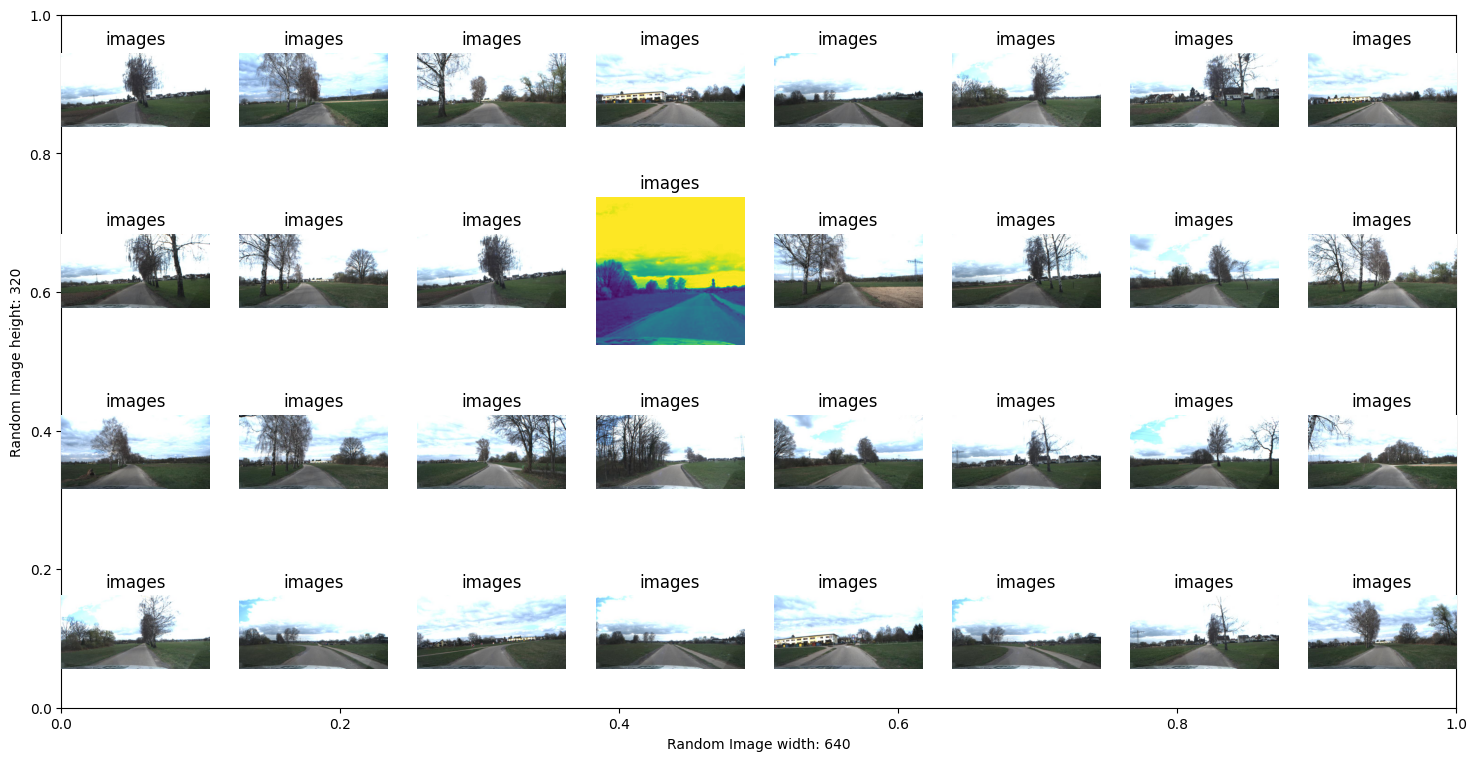

In [ ]:
from visualizing_images import plot_random_images

# get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# visualize random images
plot_random_images(image_path_list)

### 1.3 Convert the Image Data into Tensors

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.



### 1.3.1 Data Augmentation and Transform the Data

Create a Data Preparation Pipeline. (https://pytorch.org/vision/stable/transforms.html)

Note:
- Der erste Test-Datensatz nennt sich test_color und enthält 50 Bilder in Format 224×224 und in Schwarz-Weiß.
- Der zweite Test-Datensatz mit Namen test_angvel besteht aus einer vierten Szene, die ähnlich den Szenen aus dem
Train-Val Datensatzes ist, nur dass die Labels nicht vorhanden sind.

In [ ]:
# Write transform for image input
data_transform_X = transforms.Compose([

    # Keep it simple first: Resize the images to 224X224 pizels
    transforms.Resize(size=(224, 224)),

    # convert images to grayscale: https://pytorch.org/vision/stable/generated/torchvision.transforms.Grayscale.html#torchvision.transforms.Grayscale
    transforms.Grayscale(3),

    # Turn the image into a torch.Tensor, this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    transforms.ToTensor(),

])

# Write transform for image desired output
data_transform_y = transforms.Compose([

    # Keep it simple first: Resize the images to 224X224 pizels
    transforms.Resize(size=(224, 224)),

    # Turn the image into a torch.Tensor, this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    transforms.ToTensor(),

])

# Write transform for image desired output
data_transform_test = transforms.Compose([

    # Keep it simple first: Resize the images to 224X224 pizels
    transforms.Resize(size=(224, 224)),

    # convert images to grayscale: https://pytorch.org/vision/stable/generated/torchvision.transforms.Grayscale.html#torchvision.transforms.Grayscale
    transforms.Grayscale(3),

    # Turn the image into a torch.Tensor, this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    transforms.ToTensor(),

])

### 1.3.1.1 X Data Visualization

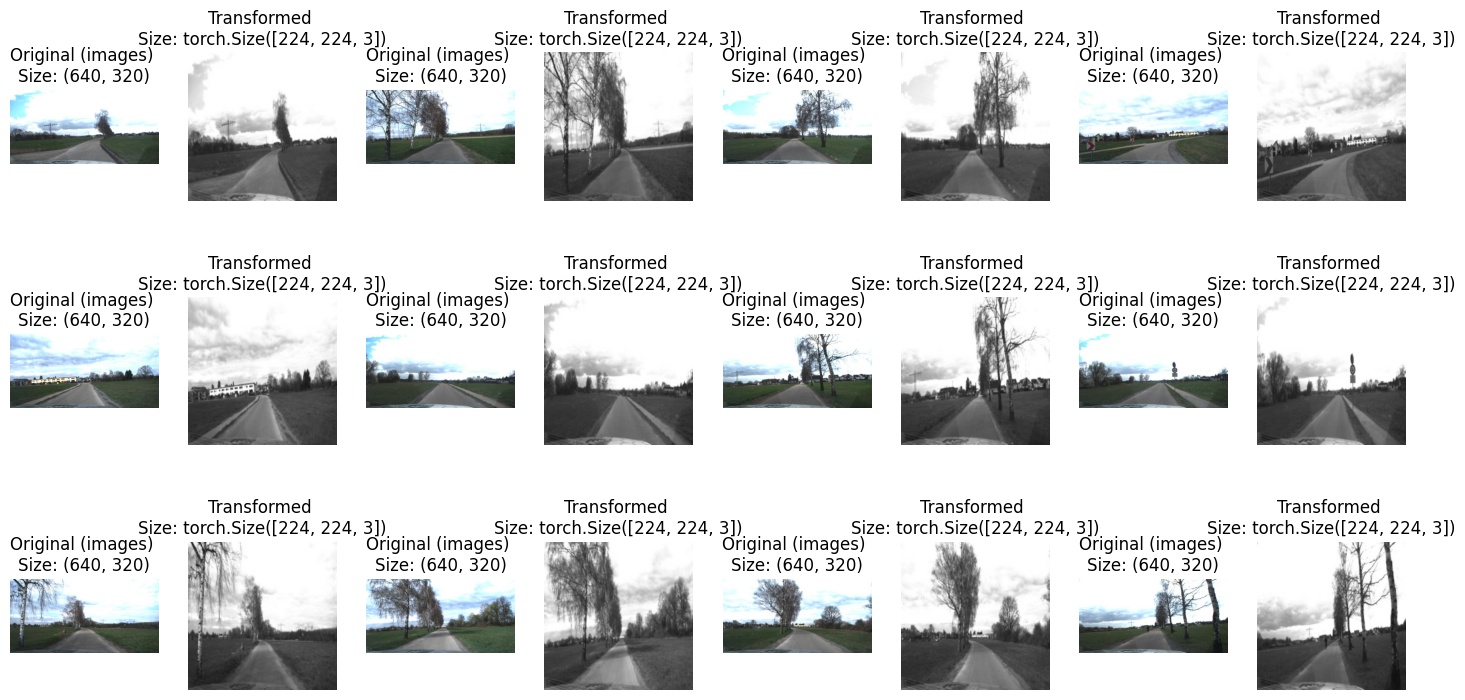

In [ ]:
from visualizing_images import plot_transformed_images

# plot random images with their transformations
plot_transformed_images(image_path_list,data_transform_X)

### 1.3.1.2 y Data Visualization

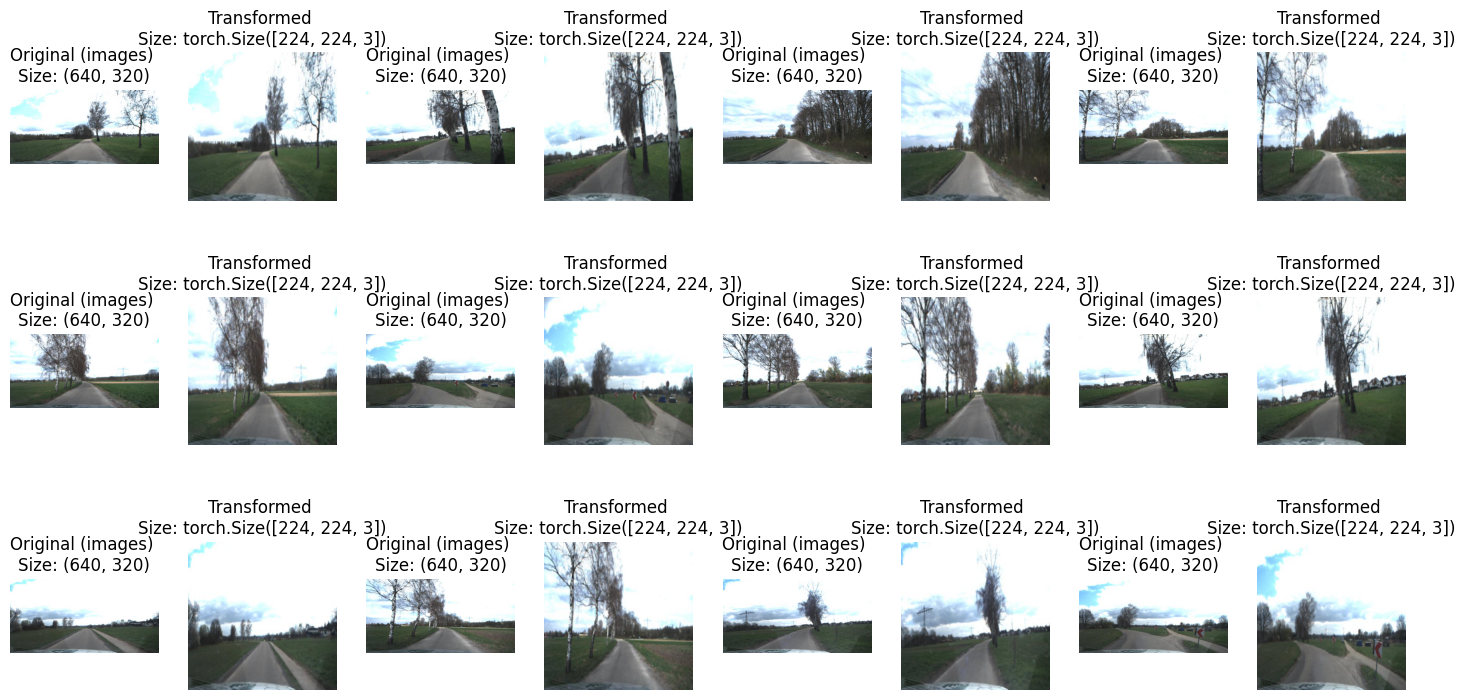

In [ ]:
from visualizing_images import plot_transformed_images

# plot random images with their transformations
plot_transformed_images(image_path_list,data_transform_y)

### 1.3.2 Loading Image Data into Pytorch Format

In [ ]:
class OwnDataset(Dataset):
    """
    All datasets are subclasses of torch.utils.data.Dataset i.e, they have __getitem__ and __len__ methods implemented.
    """

    def __init__(self, root: str, transform=None, target_transform=None):
        """This function is mandatory and initializes the dataset"""
        # Get all image paths
        self.paths = list(pathlib.Path(root).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        self.target_transform = target_transform

    def load_image(self, index: int):
        """This function opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        """This function is mandatory and returns the size of the dataset"""
        return len(self.paths)

    def __getitem__(self, index: int):
        """This function is mandatory and returns a sample of the dataset"""
        # Select sample
        img = self.load_image(index)

        # Transform if necessary
        if self.transform and self.target_transform:
            return self.transform(img), self.target_transform(img)
        else:
            return img, img

In [ ]:
# Use OwnDataset to create train dataset
train_data = OwnDataset(root=train_dir,
                                  transform=data_transform_X,
                                  target_transform=data_transform_y)

# Use OwnDataset to create validation dataset
val_data = OwnDataset(root=val_dir,
                                transform=data_transform_X,
                                target_transform=data_transform_y)

# Use OwnDataset to create validation dataset
test_data = OwnDataset(root=test_dir,
                                transform=data_transform_test,
                                target_transform=data_transform_test)

print(f"Train data length: {len(train_data)} | Val data length: {len(val_data)} | Test data length: {len(test_data)}")

Train data length: 5656 | Val data length: 1638 | Test data length: 50


### 1.6 Prepare the DataLoader

The DataLoader turns our data into a python iterable and allows us to divide the data into mini batches. (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

Why? - computational more efficient & mini batches (size k) give the network more chances to update the gradients per epoch.

In [ ]:
# batch size hyperparameter
BATCH_SIZE = 32

# construct mini batches for the train and test data
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

# check the dimensions
print(f"Length of the train DataLoader: {len(train_dataloader)} batches of {BATCH_SIZE}. (Orignially {len(train_data)})")
print(f"Length of the val DataLoader: {len(val_dataloader)} batches of {BATCH_SIZE}.  (Orignially {len(val_data)})")
print(f"Length of the test DataLoader: {len(test_dataloader)} batches of {1}.  (Orignially {len(test_data)})")

Length of the train DataLoader: 177 batches of 32. (Orignially 5656)
Length of the val DataLoader: 52 batches of 32.  (Orignially 1638)
Length of the test DataLoader: 50 batches of 1.  (Orignially 50)


### 1.5 Check the Data and Extract Key Features

Batch shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]


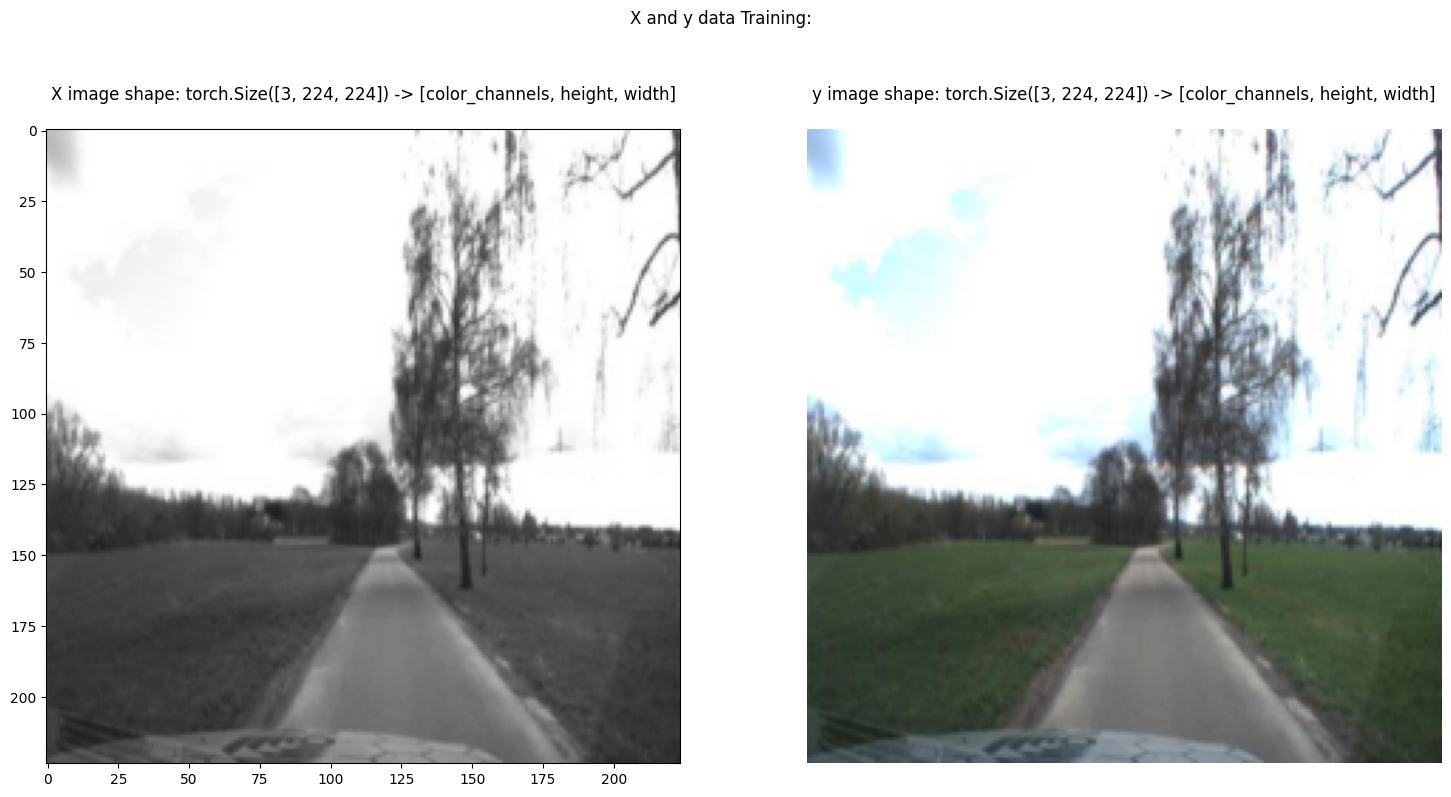

In [ ]:
# get dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))

# extract an image
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
train_img, train_label = train_features_batch[random_idx], train_labels_batch[random_idx]

# plot image and label image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle(f"X and y data Training:")
ax1.imshow(train_img.permute(1, 2, 0))
ax2.imshow(train_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {train_img.shape} -> [color_channels, height, width]\n")
ax2.set_title(f"y image shape: {train_label.shape} -> [color_channels, height, width]\n")
plt.axis(False)

# image and Label shape after batching
print(f"Batch shape: {train_features_batch.shape} -> [batch_size, color_channels, height, width]")

Batch shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]


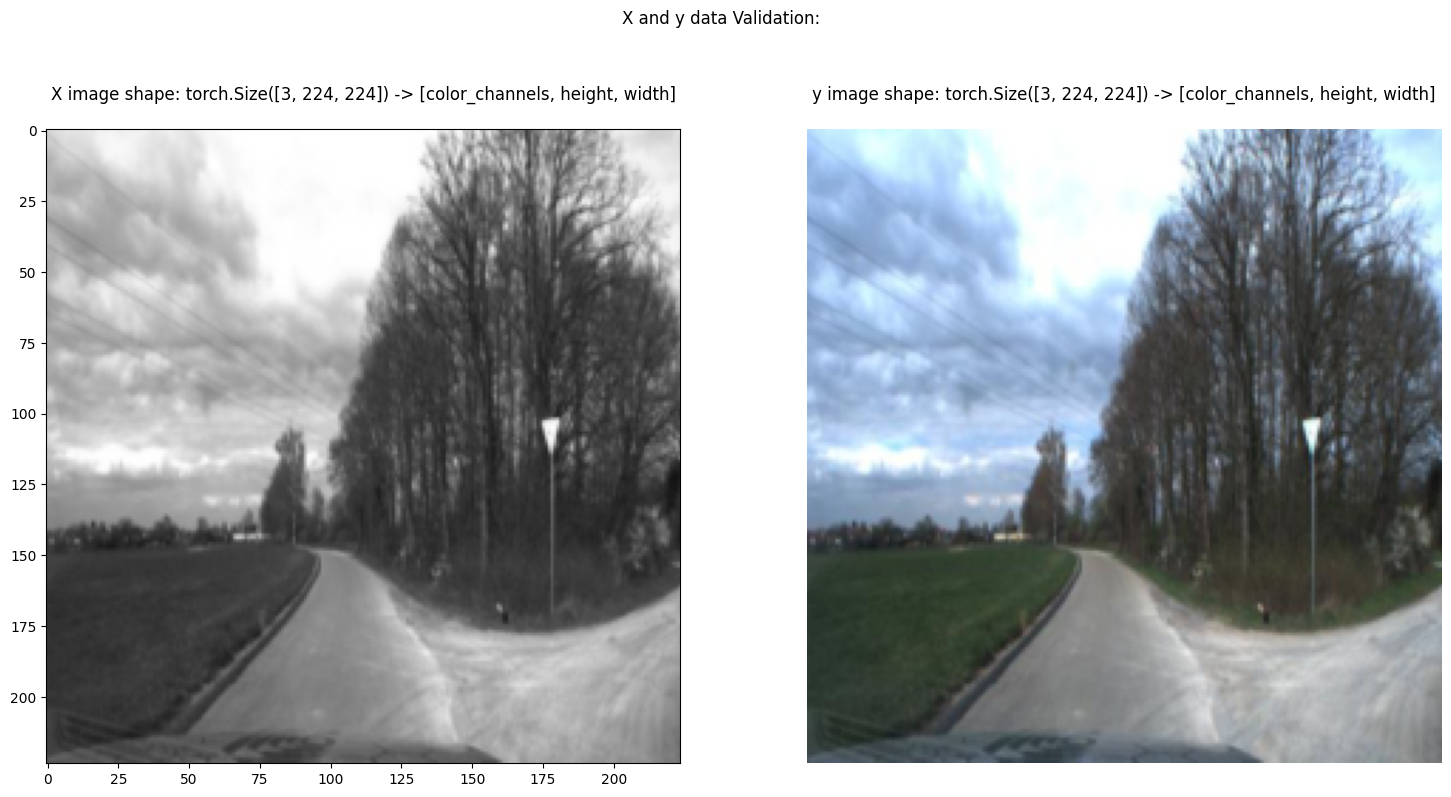

In [ ]:
# get dataloader
val_features_batch, val_labels_batch = next(iter(val_dataloader))

# extract an image
random_idx = torch.randint(0, len(val_features_batch), size=[1]).item()
val_img, val_label = val_features_batch[random_idx], val_labels_batch[random_idx]

# plot image and label image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle(f"X and y data Validation:")
ax1.imshow(val_img.permute(1, 2, 0))
ax2.imshow(val_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {val_img.shape} -> [color_channels, height, width]\n")
ax2.set_title(f"y image shape: {val_label.shape} -> [color_channels, height, width]\n")
plt.axis(False)

# image and Label shape after batching
print(f"Batch shape: {val_features_batch.shape} -> [batch_size, color_channels, height, width]")

Batch shape: torch.Size([1, 3, 224, 224]) -> [batch_size, color_channels, height, width]


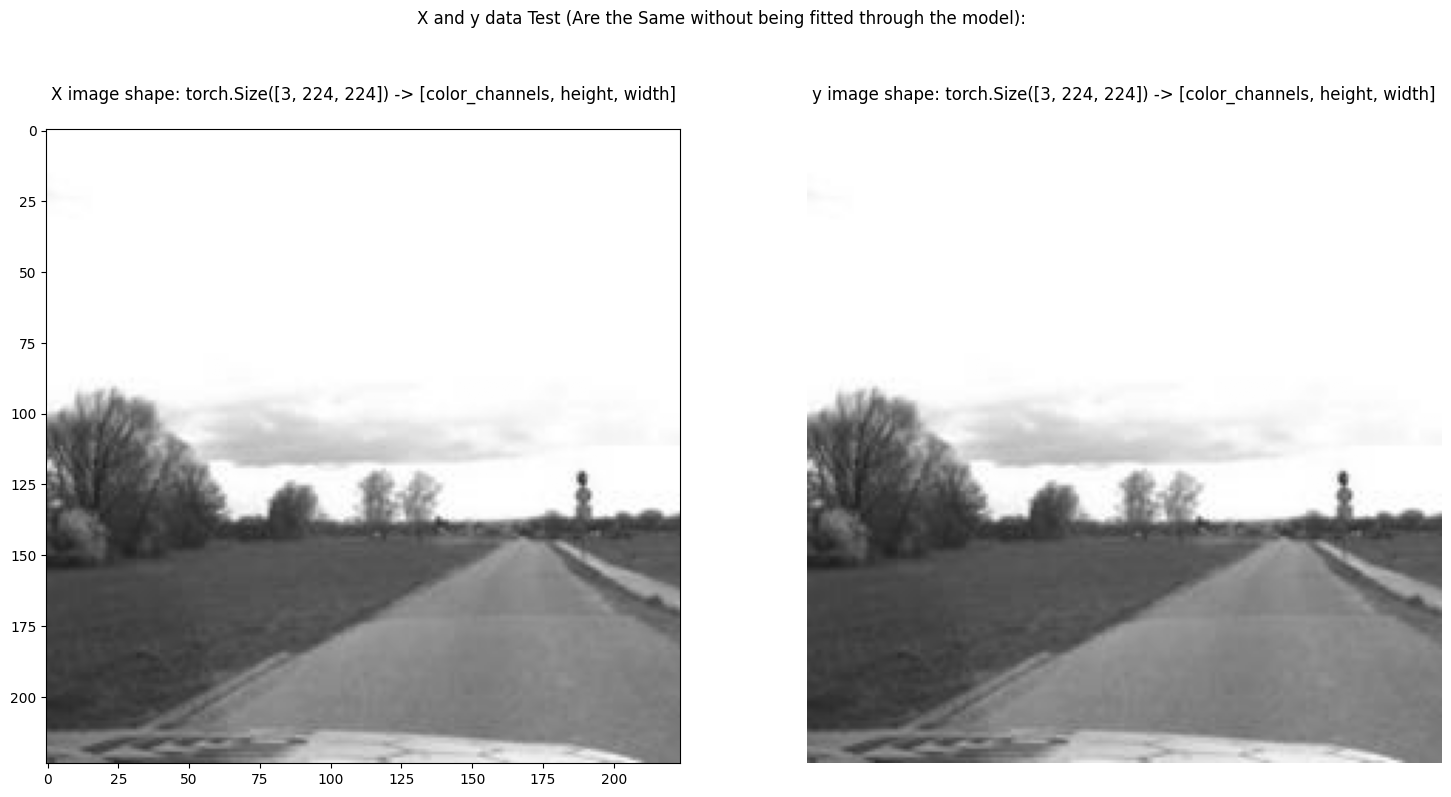

In [ ]:
# get dataloader
test_features_batch, test_labels_batch = next(iter(test_dataloader))

# extract an image
random_idx = torch.randint(0, len(test_features_batch), size=[1]).item()
test_img, test_label = test_features_batch[random_idx], test_labels_batch[random_idx]

# plot image and label image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle(f"X and y data Test (Are the Same without being fitted through the model):")
ax1.imshow(test_img.permute(1, 2, 0))
ax2.imshow(test_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {test_img.shape} -> [color_channels, height, width]\n")
ax2.set_title(f"y image shape: {test_label.shape} -> [color_channels, height, width]\n")
plt.axis(False)

# image and Label shape after batching
print(f"Batch shape: {test_features_batch.shape} -> [batch_size, color_channels, height, width]")

### 2. Build and train your model

1. Build your own model or use an existing architecture
1. Pick a loss function and optimizer

### 2.1 Build your own model or use an existing architecture

1. Build the model (Optional: Transfer learning: adjust classifier)
2. Create a model instance

In [ ]:
# build the model (start with a baseline model and increase the complexity or use an exisiting model architecture)
class Encoder(nn.Module):
  """This is the Pytorch Downsample Encoder class. Since it inherits from nn.Module we have to override the forward() method"""

  def __init__(self, input_shape:int,output_shape:int):
    """Constructor Initialization. Calls the super constructor and initializes our model."""

    # call the super constructor
    super().__init__()

    # create the model
    self.block_1 = nn.Sequential(

        # 2 Convolution Layer
        nn.Conv2d(in_channels=input_shape,out_channels=output_shape, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_shape),

        nn.Conv2d(in_channels=output_shape,out_channels=output_shape, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_shape),

        # activation fucntion
        nn.ReLU(),

    )

    # create the model
    self.block_2 = nn.Sequential(

        # downsample
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

  def forward(self,X):
    """
    This function is mandatory in each pytorch model and calculates the foward pass.
    Note: to speed up the training time, don't reassign the values to X (memory intensive).

    :param X: tensor: The X data
    :return y: tensor: The y data (prediction)
    """

    X = self.block_1(X)

    # downsampling
    X_down = self.block_2(X)

    return X, X_down

In [ ]:
# build the model (start with a baseline model and increase the complexity or use an exisiting model architecture)
class Decoder(nn.Module):
  """This is the Pytorch Upsample Decoder class. Since it inherits from nn.Module we have to override the forward() method"""

  def __init__(self, input_shape:int,output_shape:int):
    """Constructor Initialization. Calls the super constructor and initializes our model."""

    # call the super constructor
    super().__init__()

    # create the model
    self.block_1 = nn.Sequential(

        # upsample
        nn.ConvTranspose2d(in_channels=input_shape,out_channels=output_shape, kernel_size=2, stride=2, padding=0),

    )

    # create the model
    self.block_2 = nn.Sequential(

        # 2 Convolution Layer
        nn.Conv2d(in_channels=output_shape*2,out_channels=output_shape, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_shape),
        nn.Conv2d(in_channels=output_shape,out_channels=output_shape, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_shape),

        # activation fucntion
        nn.ReLU(),
    )

  def forward(self,X, X_skip):
    """
    This function is mandatory in each pytorch model and calculates the foward pass.
    Note: to speed up the training time, don't reassign the values to X (memory intensive).

    :param X: tensor: The X data
    :return y: tensor: The y data (prediction)
    """

    # Upsample
    X = self.block_1(X)

    # add propr information
    X = torch.cat([X, X_skip], axis=1)

    # compute output
    X = self.block_2(X)

    return X

In [ ]:
# build the model (start with a baseline model and increase the complexity or use an exisiting model architecture)
class UModel(nn.Module):
  """This is the Pytorch Model class. Since it inherits from nn.Module we have to override the forward() method"""

  def __init__(self, input_shape:int,output_shape:int):
    """Constructor Initialization. Calls the super constructor and initializes our model."""

    # call the super constructor
    super().__init__()

    # encoder
    self.encoder_1 = Encoder(input_shape, 64)
    self.encoder_2 = Encoder(64, 128)
    self.encoder_3 = Encoder(128, 256)
    self.encoder_4 = Encoder(256, 512)

    # bottleneck
    self.bottleneck = nn.Sequential(

        # 2 Convolution Layer
        nn.Conv2d(512, 1024, kernel_size=3, padding=1),
        nn.BatchNorm2d(1024),
        nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
        nn.BatchNorm2d(1024),

        # activation fucntion
        nn.ReLU(),
    )

    # decoder
    self.decoder_1 = Decoder(1024, 512)
    self.decoder_2 = Decoder(512, 256)
    self.decoder_3 = Decoder(256, 128)
    self.decoder_4 = Decoder(128, 64)

    # classifier
    self.classifier = nn.Conv2d(64, output_shape, kernel_size=1, padding=0)


  def forward(self,X):
    """
    This function is mandatory in each pytorch model and calculates the foward pass.
    Note: to speed up the training time, don't reassign the values to X (memory intensive).

    :param X: tensor: The X data
    :return y: tensor: The y data (prediction)
    """

    # encoder
    X_1, X_down_1 = self.encoder_1(X)
    X_2, X_down_2 = self.encoder_2(X_down_1)
    X_3, X_down_3 = self.encoder_3(X_down_2)
    X_4, X_down_4 = self.encoder_4(X_down_3)

    # bottleneck
    X_5 = self.bottleneck(X_down_4)

    # decoder
    X_6 = self.decoder_1(X_5, X_4)
    X_7 = self.decoder_2(X_6, X_3)
    X_8 = self.decoder_3(X_7, X_2)
    X_9 = self.decoder_4(X_8, X_1)

    # classifier
    X_10 = self.classifier(X_9)

    return X_10

In [ ]:
# input shape (Image is without batch, so first of shape tupel)
input_shape = train_img.shape[0]

# output shape (Identical to input_shape)
output_shape = train_img.shape[0]

# Create a model instance of your own model
model = UModel(input_shape=input_shape,output_shape = output_shape).to(device)

# print (Take shape of DataLoader, otherwise missing the batch dimension)
print(summary(model,input_size=list(train_features_batch.shape)))


Layer (type:depth-idx)                   Output Shape              Param #
UModel                                   [32, 3, 224, 224]         --
├─Encoder: 1-1                           [32, 64, 224, 224]        --
│    └─Sequential: 2-1                   [32, 64, 224, 224]        --
│    │    └─Conv2d: 3-1                  [32, 64, 224, 224]        1,792
│    │    └─BatchNorm2d: 3-2             [32, 64, 224, 224]        128
│    │    └─Conv2d: 3-3                  [32, 64, 224, 224]        36,928
│    │    └─BatchNorm2d: 3-4             [32, 64, 224, 224]        128
│    │    └─ReLU: 3-5                    [32, 64, 224, 224]        --
│    └─Sequential: 2-2                   [32, 64, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [32, 64, 112, 112]        --
├─Encoder: 1-2                           [32, 128, 112, 112]       --
│    └─Sequential: 2-3                   [32, 128, 112, 112]       --
│    │    └─Conv2d: 3-7                  [32, 128, 112, 112]       73,856
│ 

Text(0.5, 1.0, 'True image shape: torch.Size([3, 224, 224])\n')

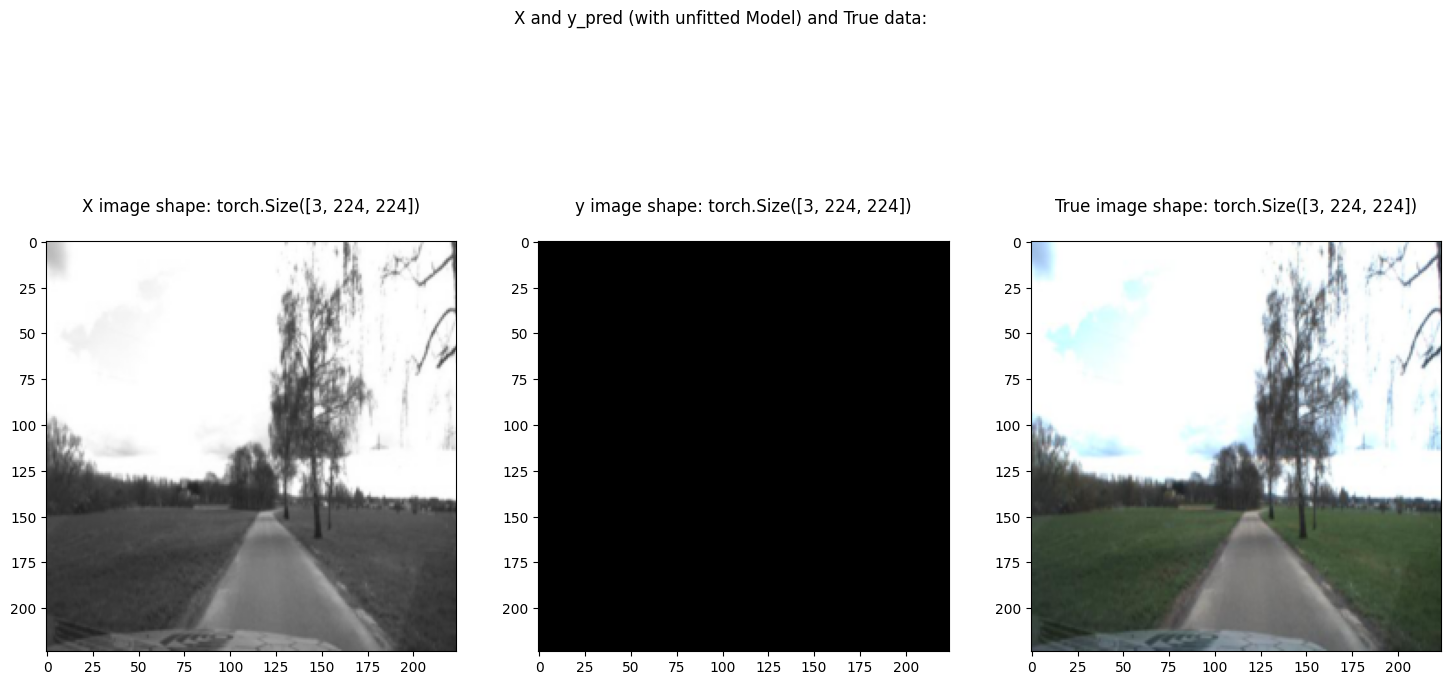

In [ ]:
# perform a forward pass on a single image in the train data
model.eval()
with torch.inference_mode():
    X_dummy = model(train_img.unsqueeze(dim=0).to(device))

# plot image model output and label
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))
fig.suptitle(f"X and y_pred (with unfitted Model) and True data:")
ax1.imshow(train_img.permute(1, 2, 0))
ax2.imshow(X_dummy.cpu().squeeze().permute(1, 2, 0))
ax3.imshow(train_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {train_img.shape}\n")
ax2.set_title(f"y image shape: {X_dummy.squeeze().shape}\n")
ax3.set_title(f"True image shape: {train_label.shape}\n")

### 2.2 Pick a loss function & optimizer

1. Available loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
2. Available optimizer: https://pytorch.org/docs/stable/optim.html#algorithms



In [ ]:
# experiment tracking
%load_ext tensorboard

# set up a loss function
loss_function = nn.MSELoss()

# learning rate
LEARNING_RATE = 0.01

# setup an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
import pandas as pd
import torch
from tqdm.auto import tqdm
import torchmetrics

def training(EPOCHS: int, model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
             val_dataloader: torch.utils.data.DataLoader, loss_function: torch.nn.Module,
             optimizer: torch.optim.Optimizer, epoch_print: int, writer: torch.utils.tensorboard.writer.SummaryWriter,
             device: torch.device = "cpu"):
    """

    This function trains the model and prints the training and validation loss per epoch.

    :param EPOCHS: int: Number of epochs to train the model.
    :param model: object: Model to train.
    :param train_dataloader: object: Dataloader for the training data.
    :param val_dataloader: object: Dataloader for the validation data.
    :param loss_function: object: Loss function to use.
    :param optimizer: object: Optimizer to use.
    :param epoch_print: int: print each epoch_print epochs.
    :param writer: torch.utils.tensorboard.writer.SummaryWriter: Tensorboard writer.
    :param device: string: Device to use. Defaults to "cpu".
    :return: df_scores: pandas.DataFrame: Dataframe with the training and validation loss per epoch and predictions of the last epoch.
    """

    # print
    print(f"Starting training.")

    # dict with empty lists to store the loss values
    results = {"Epoch": [],
               "Train Loss": [],
               "Validation Loss": [],
               }

    # create a training and test loop
    for epoch in tqdm(range(EPOCHS)):

        # train loss counter
        batch_train_loss = 0

        # model to train mode
        model.train()

        # training: loop thorugh the training batches
        for batch, (X_train, y_train) in enumerate(train_dataloader):
            # put data on device
            X_train, y_train = X_train.to(device), y_train.to(device)

            # calculate the forward pass
            y_pred_train = model(X_train)

            # calculate the training loss and add (accumulate) the loss to the counter
            training_loss = loss_function(y_pred_train, y_train)
            batch_train_loss += training_loss

            # optimizer zero grad
            optimizer.zero_grad()

            # calcuate the loss backwards (backpropagation)
            training_loss.backward()

            # optimizer step
            optimizer.step()

        # divide total train loss by length of train dataloader: Average training loss per batch
        batch_train_loss /= len(train_dataloader)

        # validation loss counter
        batch_val_loss = 0

        # model to validation mode
        model.eval()

        # inference mode diasables gradient tracking
        with torch.inference_mode():

            # validation: loop thorugh the validation batches
            for batch, (X_val, y_val) in enumerate(val_dataloader):
                # put data on device
                X_val, y_val = X_val.to(device), y_val.to(device)

                # calculate the forward pass
                y_pred_val = model(X_val)

                # calculate the validation loss and add (accumulate) the loss to the counter
                val_loss = loss_function(y_pred_val, y_val)
                batch_val_loss += val_loss

            # divide total validation loss by length of val dataloader: Average validation loss per batch
            batch_val_loss /= len(val_dataloader)

        # append the loss values to the lists
        results["Epoch"].append(epoch)
        results["Train Loss"].append(batch_train_loss.detach().cpu().numpy())
        results["Validation Loss"].append(batch_val_loss.detach().cpu().numpy())

        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"Train Loss": batch_train_loss,
                                            "Validation Loss": batch_val_loss},
                           global_step=epoch)

        # Track the PyTorch model architecture, and pass in an example input
        writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224).to(device))

        # print every epochs
        if epoch % epoch_print == 0:
            # print
            print(f"Epoch: {epoch+1} / {EPOCHS}\n-------")
            print(
                f"Train Loss: {batch_train_loss:.5f} | Validation Loss:{batch_val_loss:.5f}\n")

    # Close the writer
    writer.close()

    # convert the lists to pandas dataframe for plotting
    df_scores = pd.DataFrame(results)

    # print
    print(f"Finished training.")

    return df_scores

### 3. Model Training

In [ ]:
# from training import training
from pytorch_helper_functions import print_train_time, create_writer

# number of epochs
EPOCHS = 20

# Create a writer
writer = create_writer(experiment_name=f"ML2-Dataset",
                               model_name=f"{model.__class__.__name__}",
                               extra=f"epochs_{EPOCHS}")

# timing
train_time_start = timer()

# train and valudation loop
df_scores = training(EPOCHS=EPOCHS, model=model, train_dataloader=train_dataloader,
             val_dataloader=val_dataloader, loss_function=loss_function,
             optimizer=optimizer, epoch_print=1, writer=writer, device=device)

# calculate the training time
train_time_end = timer()
total_train_time = print_train_time(train_time_start, train_time_end, device=str(next(model.parameters()).device))

Created SummaryWriter, saving to: runs/2023-06-19/ML2-Dataset/UModel/epochs_20.
Starting training.


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### 4. Model Evaluation

1. Learning Curve

### 4.1 Plot the training and validation Learning curves

In [ ]:
def plot_loss_curve(df_scores: pd.DataFrame):
    """
    This function plots the loss and accuracy curves.

    :param df_scores: pd.DataFrame: Dataframe with the scores
    :return: None
    """

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(df_scores["Epoch"], df_scores["Train Loss"], label='Train Loss')
    plt.plot(df_scores["Epoch"], df_scores["Validation Loss"], label='Validation Loss')
    plt.title('Loss:')
    plt.xlabel('Epochs:')
    plt.legend()

    return None

In [ ]:
# from validation import plot_loss_curve

# plot the loss
plot_loss_curve(df_scores)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3, 224, 224])) that is different to the input size (torch.Size([1, 3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0.5, 1.0, 'True image shape: torch.Size([3, 224, 224])\n')

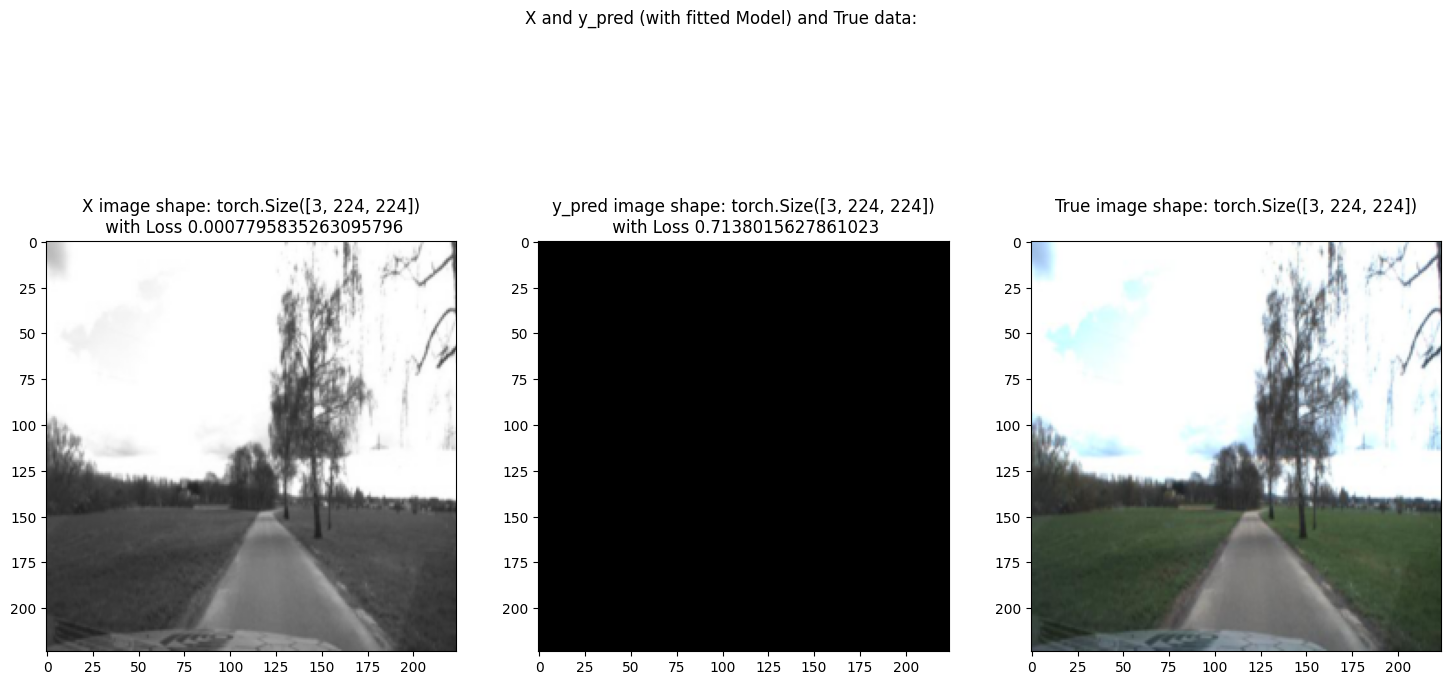

In [ ]:
# perform a forward pass on a single image in the train data
model.eval()
with torch.inference_mode():
    X_dummy = model(train_img.unsqueeze(dim=0).to(device))

# plot image model output and label
loss_xy = loss_function(train_img, train_label)
loss_yy_pred = loss_function(X_dummy.cpu(), train_label)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))
fig.suptitle(f"X and y_pred (with fitted Model) and True data:")
ax1.imshow(train_img.permute(1, 2, 0))
ax2.imshow(X_dummy.cpu().squeeze().permute(1, 2, 0))
ax3.imshow(train_label.permute(1, 2, 0))
ax1.set_title(f"X image shape: {train_img.shape}\n with Loss {loss_xy}")
ax2.set_title(f"y_pred image shape: {X_dummy.squeeze().shape}\n with Loss {loss_yy_pred}")
ax3.set_title(f"True image shape: {train_label.shape}\n")

### 5. Tracking Experiments in Tensorboard

In [ ]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
%tensorboard --logdir runs

### 6. Saving and loading a model

In [ ]:
from pytorch_helper_functions import save_model, load_model

# create directory models if it doesn't exist
MODEL_PATH = Path("models")


# If the image folder doesn't exist, download it and prepare it
if MODEL_PATH.is_dir():
    print(f"{MODEL_PATH} directory already exists. Skipping dowload.")
else:
  # create a dictionary
  MODEL_PATH.mkdir(parents=True)

# name the model, model_name should end with '.pt' or '.pth'
MODEL_NAME = f"{model.__class__.__name__}.pth"

# create the model path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

### 6.1 Save the model

In [ ]:
# save the sate dict of your trained model(recommended)
save_model(model, MODEL_SAVE_PATH)

### 6.2 Load the model

If you save just the parameters of the model and not the entire model, we have to create a new instance of your model class and load the saved stat_dict() into the new model

In [ ]:
# create an instance of the new model
model = UModel(input_shape=input_shape,output_shape = output_shape).to(device)

# load the saved sate dict in the model
load_model(model, MODEL_SAVE_PATH)

### 7. Make Final Predicitons

In [ ]:
def make_predictions(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module, device: torch.device = "cpu"):
    """
    This function makes a prediction on the data X with the model.

    :param data_loader: torch.utils.data.DataLoader: Data to make a prediction on.
    :param model: object: Model to make a prediction with.
    :param device: string: Device to use. Defaults to "cpu".
    :return: pred_values: lists: Predictions and true value of the model.
    """

    # empy tensor to store values
    pred_values = torch.empty(size=(50,3,224,224))

    # make sure the model is on the target device
    model.to(device)

    # turn on model evaluation mode
    model.eval()

    # turn on inference mode
    with torch.inference_mode():

        # training: loop thorugh the training batches
        for batch, (X, y) in enumerate(data_loader):

            # put data on device
            X, y = X.to(device), y.to(device)

            # Make a prediction
            y_pred = model(X)

            # stack tensors
            pred_values[batch] = y_pred

    return pred_values

In [ ]:
# make final predictions
y_pred_test = make_predictions(test_dataloader, model=model, device=device)

print(f"Shape of final Test Data: {y_pred_test.shape}")
print(f"One Example Image: {y_pred_test[0]}")

AttributeError: ignored

Sie dürfen die Reihenfolge der Testbilder nicht verändern.

- Ihre Abgabe muss ein numpy array mit Größe [50,224,224,3] sein, wobei die Werte ihres Arrays klassische RGB
Werte sein müssen (uint8/ Integer Werte zwischen 0 und 255)
- Sie müssen diesen array als .npy Datei abgeben. Diese Datei lässt sich mit der Methode
np.save("prediction.npy", arr)
erstellen numpy.save()
- Sollten sie ihre Eingaben für das Training normalisiert oder in andere Farbräume gebracht haben müssen sie ihre
Prädiktionen zurück in RGB konvertieren. Denken Sie auch daran, dass PyTorch standardmäßig channels first
verwendet und somit ihre Ausgabe (wenn sie alle Testdaten in einem Batch einlesen) [50,3,224,224] ist. In dem Fall
müssen Sie die Channels transponieren um eine Abgabe mit Größe [50,224,224,3] zu erzeugen.

In [ ]:
# permute
y_pred_test = y_pred_test.permute(0, 3, 2, 1)
print(f"Shape of final Test Data: {y_pred_test.shape}")

# transform to numpy array
y_pred_test = y_pred_test.cpu().detach().numpy()

# scale from [0-1] to [0-255] and convert int to an integer
y_pred_test = (y_pred_test* 255).astype('uint8')
print(f"Shape of final Test Data: {y_pred_test.shape}")
print(f"One Example Image: {y_pred_test[0]}")

# save to numy file
np.save("prediction.npy", y_pred_test)